Original Author : AustinRochford 
A Dockerfile that will produce a container with all the dependencies necessary to run this notebook is available [here](https://github.com/AustinRochford/notebooks).

In [1]:
%matplotlib inline

In [2]:
from warnings import filterwarnings

In [3]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from statsmodels.datasets import get_rdataset

In [4]:
# configure pyplot for readability when rendered as a slideshow and projected
plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

In [5]:
filterwarnings('ignore', 'findfont')

In [6]:
blue, green, red, purple, gold, teal = sns.color_palette()

pct_formatter = StrMethodFormatter('{x:.1%}')

In [7]:
SEED = 54902 # from random.org, for reproducibility

np.random.seed(SEED)

# Inférence Bayesienne avec Python and PyMC3

<center><img src='https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg'></center>

A partir du travail de [@AustinRochford](https://twitter.com/AustinRochford)

## Inférence Bayesienne

Exemple classique:

> Une maladie rare est contractée par une personne sur mille. Avec un test donnant un diagnotic juste 99.9% du temps, quelle est la probabilité qu'une personne ait la maladie si elle est testée positive?


### Probabilité conditionnelle

En théorie des probabilités, une [_probabilité conditionnelle_](https://fr.wikipedia.org/wiki/Probabilit%C3%A9_conditionnelle) est la probabilité d'un événement sachant qu'un autre événement a eu lieu.

$$
\begin{align*}
P(A\ |\ B)
    & = \textrm{La probabilité que } A \textrm{ arrive si on sait que } B \textrm{ est arrivé} \\
    & = \frac{P(A \textrm{ et } B)}{P(B)}.
\end{align*}
$$

Notre question,

Une maladie rare est contractée par une personne sur mille. Avec un test donnant un diagnotic juste 99.9% du temps, quelle est la probabilité qu'une personne ait la maladie si elle est testée positive?

devient

$$
\begin{align*}
    P(+)
        & = 10^{-5} \\
    \\
    P(\textrm{Test } +\ |\ +)
        & = 0.999 \\
    P(\textrm{Test } -\ |\ -)
        & = 0.999 \\
    \\
    P(+\ |\ \textrm{Test } +)
        & =\ \textbf{?}
\end{align*}
$$

### Théorem de Bayes

[Le théorem de Bayes](https://en.wikipedia.org/wiki/Bayes%27_theorem) nous montre comment passer de $P(B\ |\ A)$ à $P(A\ |\ B)$.

<img src='https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif' width=300> $$\large P(A\ |\ B) = \frac{P(B\ |\ A)\ P(A)}{P(B)}$$

Le terme P(A) est la <font color="orange">probabilité a priori de A</font>. Elle est « antérieure » au sens qu’elle précède toute information sur B. Le terme P(A|B) est appelée la <font color="red">probabilité conditionnelle de A sachant B </font>. Elle est « postérieure », au sens qu’elle dépend directement de B. Le terme P(B|A), pour un B connu, est appelé <font color="blue"> la fonction de vraisemblance </font> de A. De même, le terme P(B) est appelé <font color="green">la probabilité marginale </font> ou a priori de B.

$$\color{red}{P(A\ |\ B)} = \frac{\color{blue}{P(B\ |\ A)}\ \color{orange}{P(A)}}{\color{green}{P(B)}}.$$

Pour plusieurs modèles la <font color="green">la probabilité marginale </font> is **est impossible on difficilement calculable analytiquement**.

Pour le cas qui nous intéresse, on peut calculer analytiquement la probabilité avec le théorème de Bayes et la [Formule des probabilités totales](https://fr.wikipedia.org/wiki/Formule_des_probabilit%C3%A9s_totales)

$$
\begin{align*}
    P(+\ |\ \textrm{Test } +)
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +)} \\
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +\ |\ +) P(+) + P(\textrm{Test } +\ |\ -) P(-)}
\end{align*}
$$

$$
\begin{align*}
    P(+)
        & = 10^{-5} \\
    P(\textrm{Test } +\ |\ +)
        & = 0.999 \\
    P(\textrm{Test } -\ |\ -)
        & = 0.999 \\
    \\
    P(+\ |\ \textrm{Test } +)
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +\ |\ +) P(+) + P(\textrm{Test } +\ |\ -) P(-)} \\
        & = \frac{0.999 \times 10^{-5}}{0.999 \times 10^{-5} + 0.001 \times \left(1 - 10^{-5}\right)}
\end{align*}
$$

On observe qu'une personne qui reçoit un test positif a moins de 1% de change d'avoir la maladie!

In [8]:
0.999 * 1e-5 / (0.999 * 1e-5 + 0.001 * (1 - 1e-5))

0.009891284975940117

## Programmation probabilistique pour inférence bayesienne

<center><img src="http://austinrochford.com/resources/talks/img/probabilistic_programming.png"></center>

Cet exemple était déjà complexe à exprimer et pouvait se résoudre analytiquement parce qu'il était très simple.

## Résolvons le même problème avec Python

On connait la prévalence de la maladie dans la population générale, soit 1/1000

La distribution de [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution) donne la probabilité binaire (pile ou face biaisé).  Si $X \sim \textrm{Bernoulli}(p),$

$$
\begin{align*}
P(X = 1)
    & = p \\
P(X = 0)
    & = 1 - p.
\end{align*}
$$

In [9]:
import pymc3 as pm

with pm.Model() as disease_model:
    has_disease = pm.Bernoulli('has_disease', 1e-5)


You can find the C code in this temporary file: C:\Users\myst_\AppData\Local\Temp\theano_compilation_error_1l72hu5r


Exception: Compilation failed (return status=1): C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o: In function `_import_array':. C:/Users/myst_/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1455: undefined reference to `__imp_PyExc_ImportError'. C:/Users/myst_/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1461: undefined reference to `__imp_PyExc_AttributeError'. C:/Users/myst_/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1466: undefined reference to `__imp_PyCapsule_Type'. C:/Users/myst_/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1467: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/myst_/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1482: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/myst_/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1490: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/myst_/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1496: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/myst_/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1506: undefined reference to `__imp_PyExc_RuntimeError'. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o:C:/Users/myst_/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1518: more undefined references to `__imp_PyExc_RuntimeError' follow. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o: In function `NpyCapsule_Check':. C:/Users/myst_/Anaconda3/lib/site-packages/numpy/core/include/numpy/npy_3kcompat.h:454: undefined reference to `__imp_PyCapsule_Type'. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o: In function `unpack_list_of_ssize_t':. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:48: undefined reference to `__imp_PyExc_TypeError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:58: undefined reference to `__imp_PyExc_IndexError'. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o: In function `CLazyLinker_init':. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:352: undefined reference to `__imp_PyExc_IndexError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:370: undefined reference to `__imp_PyExc_IndexError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:385: undefined reference to `__imp_PyExc_IndexError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:389: undefined reference to `__imp_PyExc_IndexError'. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o:C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:393: more undefined references to `__imp_PyExc_IndexError' follow. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o: In function `CLazyLinker_init':. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:405: undefined reference to `__imp_PyExc_TypeError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:420: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:426: undefined reference to `__imp_PyExc_IndexError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:440: undefined reference to `__imp_PyExc_TypeError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:444: undefined reference to `__imp__Py_NoneStruct'. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o: In function `c_call':. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:546: undefined reference to `__imp__Py_NoneStruct'. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o:C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:546: more undefined references to `__imp__Py_NoneStruct' follow. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o: In function `lazy_rec_eval':. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:618: undefined reference to `__imp_PyExc_IndexError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:641: undefined reference to `__imp_PyExc_TypeError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:649: undefined reference to `__imp_PyExc_ValueError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:657: undefined reference to `__imp_PyExc_IndexError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:708: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:715: undefined reference to `__imp_PyExc_TypeError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:721: undefined reference to `__imp_PyExc_TypeError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:771: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:771: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:772: undefined reference to `__imp__Py_NoneStruct'. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o: In function `CLazyLinker_call':. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:814: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:826: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:839: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:839: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:840: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:849: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:849: undefined reference to `__imp__Py_NoneStruct'. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o:C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:850: more undefined references to `__imp__Py_NoneStruct' follow. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o: In function `CLazyLinker_call':. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:894: undefined reference to `__imp_PyExc_AssertionError'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:937: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:937: undefined reference to `__imp__Py_NoneStruct'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:938: undefined reference to `__imp__Py_NoneStruct'. C:\Users\myst_\AppData\Local\Temp\cctVJrJ9.o: In function `CLazyLinker_set_allow_gc':. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:973: undefined reference to `__imp_PyBool_Type'. C:/Users/myst_/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5.2-64/lazylinker_ext/mod.cpp:976: undefined reference to `__imp__Py_TrueStruct'. collect2.exe: error: ld returned 1 exit status. 

Si la personne a la maladie, il y a 99.9% de chance de tester positif. Sinon, il y a quand même  0.1% de chance de tester positif

In [10]:
with disease_model:
    p_test_pos = has_disease * 0.999 + (1 - has_disease) * 0.001

La personne dans l'exemple a testé positive alors:

In [11]:
with disease_model:
    test_pos = pm.Bernoulli('test_pos', p_test_pos, observed=1)

Quelle est la probabilité que cette personne ait la maladie

In [12]:
with disease_model:
    disease_trace = pm.sample(draws=10000, random_seed=SEED)

Assigned BinaryGibbsMetropolis to has_disease
100%|██████████| 10500/10500 [00:04<00:00, 2427.46it/s]


On obtient un échantillionnage de la distribution postérieur, sachant que nous avons observé un test positif

In [13]:
disease_trace['has_disease']

array([0, 0, 0, ..., 0, 0, 0])

La moyenne des échantillions `has_disease` provenant de la distribution postierieure est la probabilité que cette personne ait la maladie, sachant qu'elle a testé positif

In [14]:
disease_trace['has_disease'].mean()

0.0104

In [15]:
0.999 * 1e-5 / (0.999 * 1e-5 + 0.001 * (1 - 1e-5))

0.009891284975940117

### Méthodes de Monte Carlo

[Les méthodes de Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) utilisent un échantillionnage aléatoire pour aproximer des quantités difficile a obtenir analytiquement. Ils sont un outil essentiel pour l'inférence Bayesienne où la distribution marginale est habituellement difficile à obtenir.

#### Un exemple
On génère 5000 points distribués aléatoirement dans un carré unitaire

In [13]:
N = 5000

x, y = np.random.uniform(0, 1, size=(2, N))

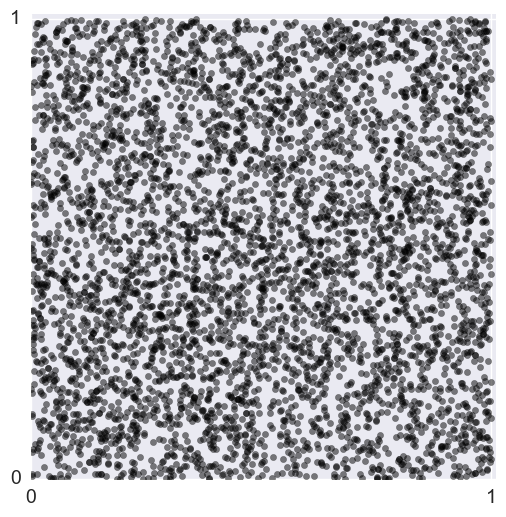

In [14]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

ax.scatter(x, y, c='k', alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

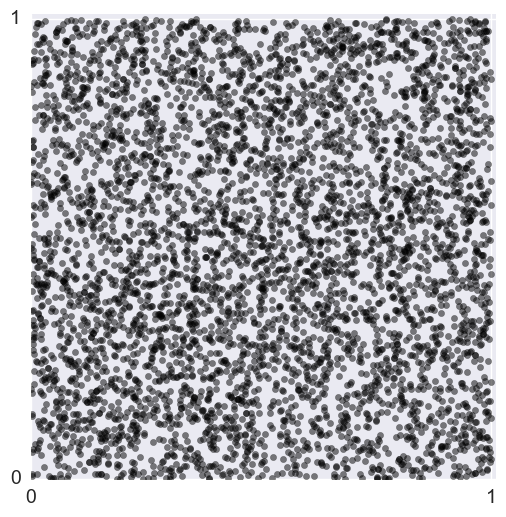

In [15]:
fig

En comptant le nombre de point qui tombent dans le quatier de cercle de rayon 1, on obtient une approximation de l'aire dans de quartier de cercle, qui est en réalité de $\frac{\pi}{4}$.

In [16]:
in_circle = x**2 + y**2 <= 1

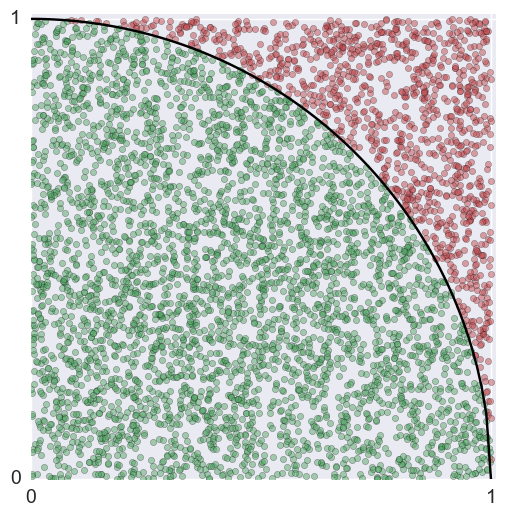

In [17]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, np.sqrt(1 - x_plot**2), c='k');

ax.scatter(x[in_circle], y[in_circle], c=green, alpha=0.5);
ax.scatter(x[~in_circle], y[~in_circle], c=red, alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

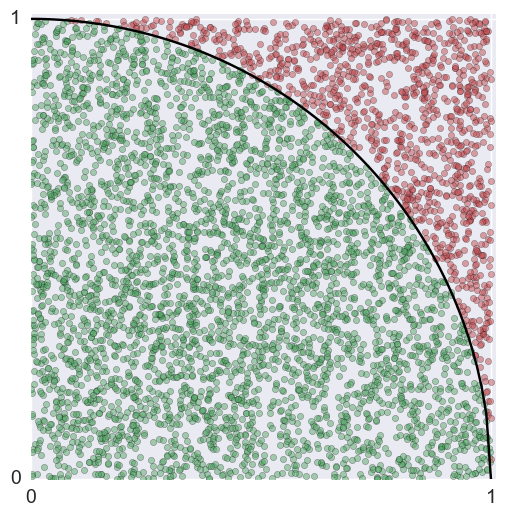

In [18]:
fig

Comme on s'y attend, 4 fois l'approximation du quart de l'air donne près de $\pi$. Plus d'échantillions donnerais une meilleur approximation

In [19]:
4 * in_circle.mean()

3.1336

#### Historique des méthodes de Monte Carlo

<center><img src="http://www.bgu.ac.il/~oaharon/feynman/Feynman_Portraits_files/Ulam_Feynman_von_Neumann.jpg"></center>

Les méthodes de Monte Carlo ont été largement utilisées pour le [Projet Manhattan](https://en.wikipedia.org/wiki/Monte_Carlo_method#Definitions).  Sur la photo ci-dessus, on voit des scientifiques du projet Manhattan [Stanislaw_Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam),[Richard Feynman](https://en.wikipedia.org/wiki/Richard_Feynman) et [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann). En travaillant sur le projet Manhattan, Ulam a donné l'une des premières descriptions des algorithmes des [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Monte_Carlo). La librairie de programmation probabiliste [Stan](http://mc-stan.org/) est nommé en son honneur.

## Le problème de Monty Hall

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png'></center>

Le [problème de Monty Hall](https://en.wikipedia.org/wiki/Monty_Hall_problem) est un célèbre puzzle de probabilité, basé sur l'émission de jeux des années 1960 [Let's Make a Deal](https://en.wikipedia.org/wiki/Let%27s_Make_a_Deal) et nommé d'après son hôte d'origine. Dans le jeu, un concurrent se voyait présenter trois portes, dont deux contenaient un article de peu ou pas de valeur (par exemple, une chèvre) et l'une d'entre elles contenait un article de très grande valeur (par exemple, une voiture de luxe). Le concurrent devait d'abord deviner quelle porte contenait la voiture de sport. Après la devinette initiale du concurrent, Monty ouvrait l'une des deux autres portes, révélant une chèvre. Monty offrait alors au concurrent la chance de changer leur choix de porte. Le problème du Monty Hall pose la question suivante : le candidat doit-il conserver son choix initial de porte ou le changer ?



Au départ, nous n'avons aucune information sur la porte derrière laquelle se trouve le prix.

In [23]:
with pm.Model() as monty_model:
    prize = pm.DiscreteUniform('prize', 0, 2)

If we choose door one:

<table>
    <tr>
        <td></td>
        <th colspan="3"><center>Monty can open</center></th>
    </tr>
    <tr>
        <th>Prize behind</th>
        <td>Door 1</td>
        <td>Door 2</td>
        <td>Door 3</td>
    </tr>
    <tr>
        <td>Door 1</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 3</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
    </tr>
</table>

In [24]:
from theano import tensor as tt

with monty_model:
    p_open = pm.Deterministic('p_open',
                              tt.switch(tt.eq(prize, 0),
                                        # it is behind the first door
                                        np.array([0., 0.5, 0.5]),
                              tt.switch(tt.eq(prize, 1),
                                        # it is behind the second door
                                        np.array([0., 0., 1.]),
                                        # it is behind the third door
                                        np.array([0., 1., 0.]))))

Monty ouvre la porte 3 contenant une chèvre

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png'></center>

In [25]:
with monty_model:
    opened = pm.Categorical('opened', p_open, observed=2)

Doit-on changer de choix?

In [26]:
with monty_model:
    monty_trace = pm.sample(draws=10000, random_seed=SEED)
    
monty_df = pm.trace_to_dataframe(monty_trace)

Assigned Metropolis to prize
100%|██████████| 10500/10500 [00:02<00:00, 4427.89it/s]


In [27]:
monty_df.prize.head()

0    0
1    0
2    0
3    0
4    1
Name: prize, dtype: int64

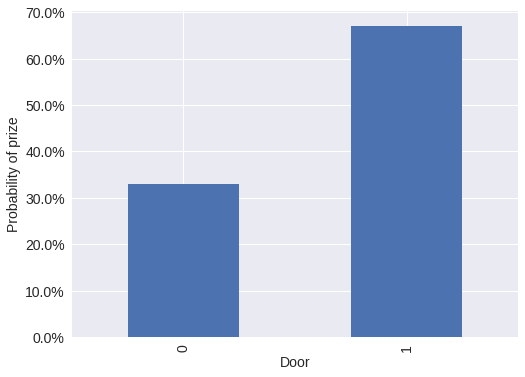

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = (monty_df.groupby('prize')
              .size()
              .div(monty_df.shape[0])
              .plot(kind='bar', ax=ax))

ax.set_xlabel("Door");

ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Probability of prize");

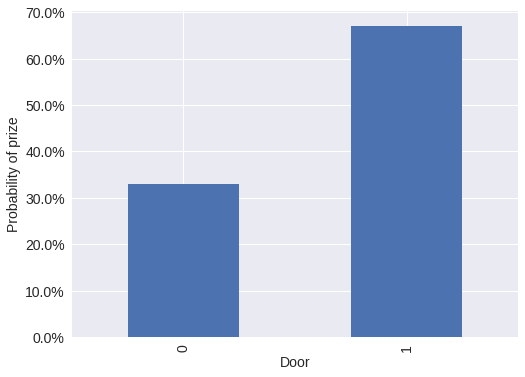

In [29]:
fig

Donc, oui on devrait changer de porte

**En option**

We can also resolve the Monty Hall problem with pen and paper, as follows.

Throughout this calculation, all probabilities assume that we have initially chosen the first door.  By Bayes' Theorem, the probability that the sportscar is behind door one given that Monty opened door three is

$$P(\textrm{Behind door one}\ |\ \textrm{Opened door three}) = \frac{P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one})}{P(\textrm{Opened door three})}.$$

The a priori probability that the prize is behind any of the doors is one third.  From the table above, $P(\textrm{Opened door three}\ |\ \textrm{Behind door one}) = \frac{1}{2}$.  We calculate $P(\textrm{Opened door three})$ using the law of total probability as follows:

$$
\begin{align*}
P(\textrm{Opened door three})
    & = P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one}) \\
    & + P(\textrm{Opened door three}\ |\ \textrm{Behind door two})P(\textrm{Behind door two}) \\
    & + P(\textrm{Opened door three}\ |\ \textrm{Behind door three})P(\textrm{Behind door three}) \\
    & = \frac{1}{2} \cdot \frac{1}{3} + 1 \cdot \frac{1}{3} + 0 \cdot \frac{1}{3} \\
    & = \frac{1}{2}.
\end{align*}
$$

Therefore

$$
\begin{align*}
P(\textrm{Behind door one}\ |\ \textrm{Opened door three})
    & = \frac{P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one})}{P(\textrm{Opened door three})} \\
    & = \frac{\frac{1}{2} \cdot \frac{1}{3}}{\frac{1}{3}} \\
    & = \frac{1}{3}.
\end{align*}$$

Since $P(\textrm{Behind door three}\ |\ \textrm{Opened door three}) = 0$, because Monty wants the contestant's choice to be suspensful, $P(\textrm{Behind door two}\ |\ \textrm{Opened door three}) = \frac{2}{3}$.  Therefore it is correct to switch doors, confirming our computational results.

## Introduction à PyMC3

<center><img src='https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg'></center>

De la [Documentation de PyMC3](http://pymc-devs.github.io/pymc3/):

> PyMC3 is a Python package for Bayesian statistical modeling and Probabilistic Machine Learning which focuses on advanced Markov chain Monte Carlo and variational fitting algorithms. Its flexibility and extensibility make it applicable to a large suite of problems.

[![License](https://img.shields.io/badge/License-Apache%202.0-blue.svg)](https://opensource.org/licenses/Apache-2.0)

## Étude de cas: Sleep Deprivation

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5c/%22Plenty_of_sleep_keeps_him_on_the_job%22_-_NARA_-_514792.jpg/1280px-%22Plenty_of_sleep_keeps_him_on_the_job%22_-_NARA_-_514792.jpg" width=300></center>

Les données proviennent de la librairie [`lme4`](https://cran.r-project.org/web/packages/lme4/) du language R, qui cite 

Gregory Belenky, Nancy J. Wesensten, David R. Thorne, Maria L. Thomas, Helen C. Sing, Daniel P. Redmond, Michael B. Russo and Thomas J. Balkin (2003) Patterns of performance degradation and restoration during sleep restriction and subsequent recovery: a sleep dose-response study. _Journal of Sleep Research_ 12, 1–12.

In [10]:
sleep_df = (get_rdataset('sleepstudy', 'lme4', cache=True)
                .data
                .rename(columns=str.lower)
                .assign(reaction_std=lambda df: (df.reaction - df.reaction.mean()) / df.reaction.std()))

In [31]:
sleep_df.head()

,reaction,days,subject,reaction_std
0,249.5600,0,308,-0.868968
1,258.7047,1,308,-0.706623
2,250.8006,2,308,-0.846944
3,321.4398,3,308,0.407108
4,356.8519,4,308,1.035777


In this study, each subject got their normal amount of sleep on the first day.  They were reduced to three hours of sleep each subsequent day.  The `reaction` column is their average response time on a number of tests.  The `reaction_std` column is the result of [standardizing](https://en.wikipedia.org/wiki/Standard_score) `reaction` across all subjects and days.

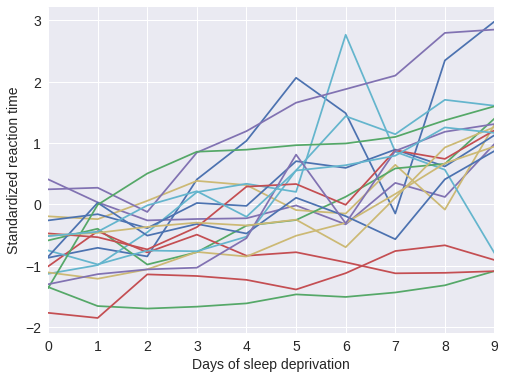

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

(sleep_df.groupby('subject')
         .plot('days', 'reaction_std',
               ax=ax, legend=False));

ax.set_xlabel("Days of sleep deprivation");
ax.set_ylabel("Standardized reaction time");

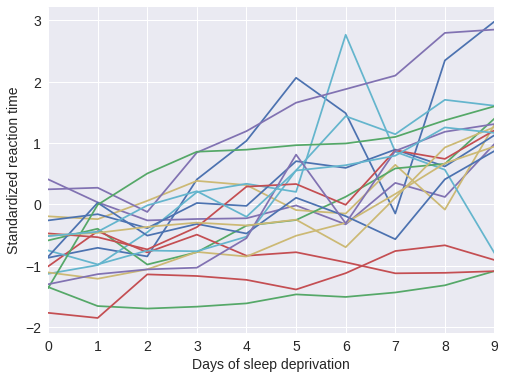

In [33]:
fig

We translate the subject ids in `sleep_df`, which start at 308, to begin at zero and increase sequentially.

In [34]:
subject_ix, subject_map = sleep_df.subject.factorize()
n_subjects = subject_map.size

days = sleep_df.days.values
reaction_std = sleep_df.reaction_std.values

Each subject has a baseline reaction time, which should not be too far apart.

In [35]:
with pm.Model() as sleep_model:
    μ_α = pm.Normal('μ_α', 0., 5.)
    σ_α = pm.HalfCauchy('σ_α', 5.)
    α = pm.Normal('α', μ_α, σ_α, shape=n_subjects)

Each subject's reaction time increases at a different rate after days of sleep deprivation.

In [36]:
with sleep_model:
    μ_β = pm.Normal('μ_β', 0., 5.)
    σ_β = pm.HalfCauchy('σ_β', 5.)
    β = pm.Normal('β', μ_β, σ_β, shape=n_subjects)

The baseline reaction time and rate of increase lead to the observed reaction times.

In [37]:
with sleep_model:
    μ = pm.Deterministic('μ', α[subject_ix] + β[subject_ix] * days)
    σ = pm.HalfCauchy('σ', 5.)
    obs = pm.Normal('obs', μ, σ, observed=reaction_std)

This type of model is known as a hierarchical (or mixed) linear model, because we allow the slope and intercept to vary by subject, but add a regularizing prior shared across subjects.  To learn more about this type of model, consuly Gelman and Hill's [_Data Analysis Using Regression and Multilevel/Hierarchical Models_](http://www.stat.columbia.edu/~gelman/arm/).

In [38]:
N_JOBS = 3
JOB_SEEDS = [SEED + i for i in range(N_JOBS)]

with sleep_model:
    sleep_trace = pm.sample(njobs=N_JOBS, random_seed=JOB_SEEDS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:07<00:00, 134.79it/s]


### Convergence Diagnostics

PyMC3 provides a number of [statistcal convergence diagnostics](http://pymc-devs.github.io/pymc3/api/stats.html) to help ensure that the samples are a good approximation to the true posterior distribution.

Energy plots and the Bayesian fraction of missing information (BFMI) are two diagnostics relevant to Hamiltonian Monte Carlo sampling, which we have used in this example.  If the two distributions in the energy plot differ significantly (espescially in the tails), the sampling was not very efficient.  The Bayesian fraction of missing information quantifies this difference with a number between zero and one.  A BFMI close to one is preferable, and a BFMI lower than 0.2 is indicative of efficiency issues.

For more information on energy plots and BFMI consult Michael Betancourt's [_A Conceptual Introduction to Hamiltonian Monte Carlo_](https://arxiv.org/abs/1701.02434) and [_Robust Statistical Workflow with PyStan_](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html).

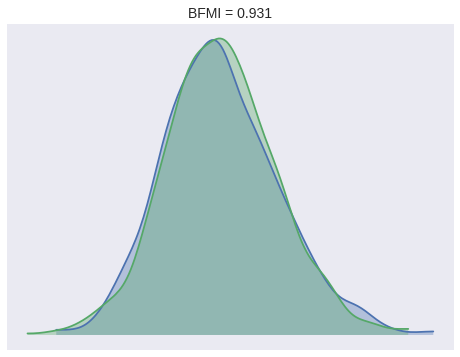

In [39]:
ax = pm.energyplot(sleep_trace, legend=False)
ax.set_title("BFMI = {:.3f}".format(pm.bfmi(sleep_trace)));

In contract to energy plots and BFMI, which are specific to Hamiltonian Monte Carlo algorithms, [Gelman-Rubin](http://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/) statistics are applicable to any MCMC algorithm, as long as multiple chains have been sampled.  Gelman-Rubin statistics near one are preferable, and values less than 1.1 are generally taken to indicate convergence.

In [40]:
max(np.max(gr_values) for gr_values in pm.gelman_rubin(sleep_trace).values())

1.0019478091296214

### Prediction

In the Bayesian framework, prediction is done by sampling from the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution), which is the distribution of possible future observations, given the current observations.

In [41]:
with sleep_model:
    pp_sleep_trace = pm.sample_ppc(sleep_trace)

100%|██████████| 500/500 [00:00<00:00, 1258.46it/s]


We convert the posterior predictive samples to a `DataFrame`.

In [42]:
PP_DATA= {'pp_{}'.format(i):  pp_col for i, pp_col in enumerate(pp_sleep_trace['obs'])}
PP_COLS = list(PP_DATA.keys())

pp_df = sleep_df.assign(**PP_DATA)

In [43]:
pp_df.head()

,reaction,days,subject,reaction_std,pp_0,pp_1,pp_10,pp_100,pp_101,pp_102,...,pp_90,pp_91,pp_92,pp_93,pp_94,pp_95,pp_96,pp_97,pp_98,pp_99
0,249.5600,0,308,-0.868968,-0.221133,-1.094005,-1.479840,-0.797150,-0.251219,-1.846100,...,-0.680005,-0.036840,-0.618054,0.158745,-0.986407,-0.788178,-1.483328,-0.423254,-0.946230,-0.838087
1,258.7047,1,308,-0.706623,0.354375,-1.192640,-0.424441,0.064195,-0.661047,-1.181403,...,-0.472364,-0.825356,-0.374235,-0.336909,-0.940759,-1.236048,-0.749208,-0.892589,0.243243,-0.891522
2,250.8006,2,308,-0.846944,0.487935,-0.570185,0.304536,0.758313,0.566803,0.211791,...,-0.512914,0.156596,-0.451047,-0.219734,-0.773714,-0.237561,-0.199602,-0.071147,0.146439,-0.193735
3,321.4398,3,308,0.407108,0.950116,-0.554748,0.544648,1.037173,-0.245327,0.450455,...,-0.183340,0.289252,0.358078,1.579609,0.652802,-0.286667,-0.327654,0.607906,-0.087981,-0.097427
4,356.8519,4,308,1.035777,0.485269,0.549079,0.564043,0.045464,0.643697,0.190714,...,0.976137,0.306833,0.744076,0.493216,0.516644,1.090693,0.583320,1.079374,0.996899,0.671175


In [44]:
def pp_subject_plot(pp_subject_df, ax):
    low = pp_subject_df[PP_COLS].quantile(0.025, axis=1)
    high = pp_subject_df[PP_COLS].quantile(0.975, axis=1)

    ax.fill_between(pp_subject_df.days, low, high,
                    color='k', alpha=0.25)

    ax.plot(pp_subject_df.days, pp_subject_df.reaction_std)
    ax.plot(pp_subject_df.days, pp_subject_df[PP_COLS].mean(axis=1),
            c='k');
    
def pp_subject_plot_helper(data=None, **_):
    pp_subject_plot(data, plt.gca())

The following plot shows the predicted and observed reaction times for each subjects.

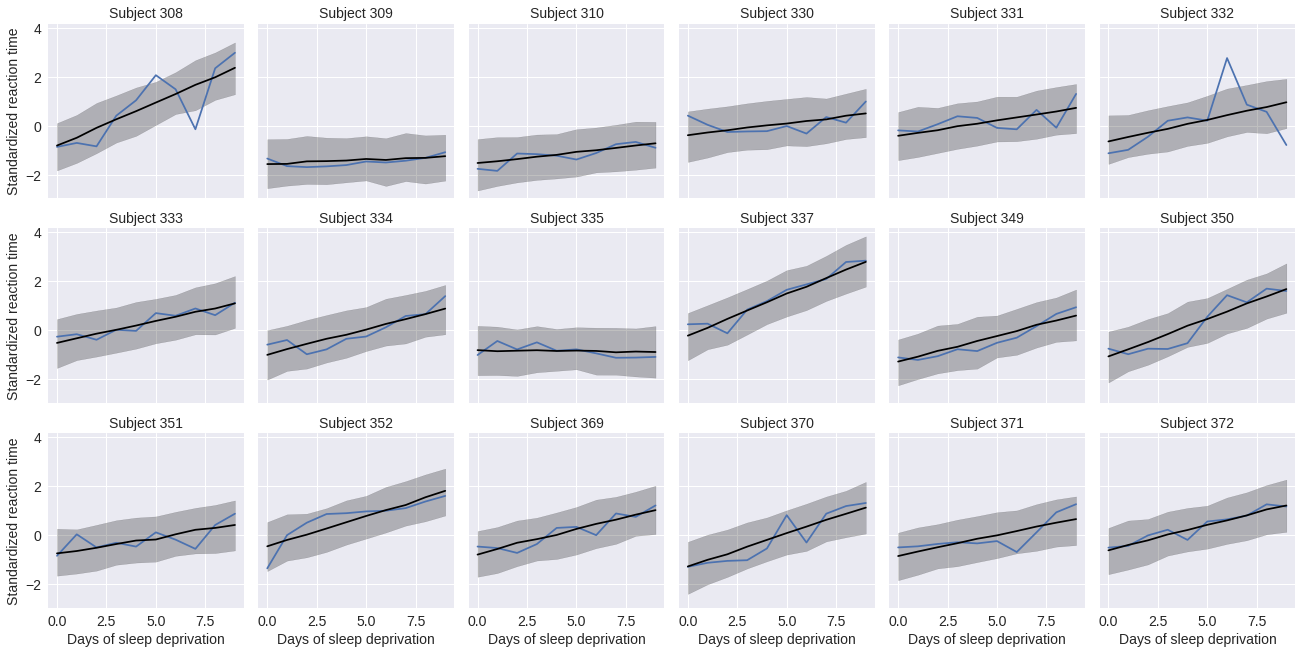

In [45]:
grid = sns.FacetGrid(pp_df, col='subject', col_wrap=n_subjects // 3)
grid.map_dataframe(pp_subject_plot_helper);

grid.set_axis_labels("Days of sleep deprivation", "Standardized reaction time");
grid.set_titles("Subject {col_name}");

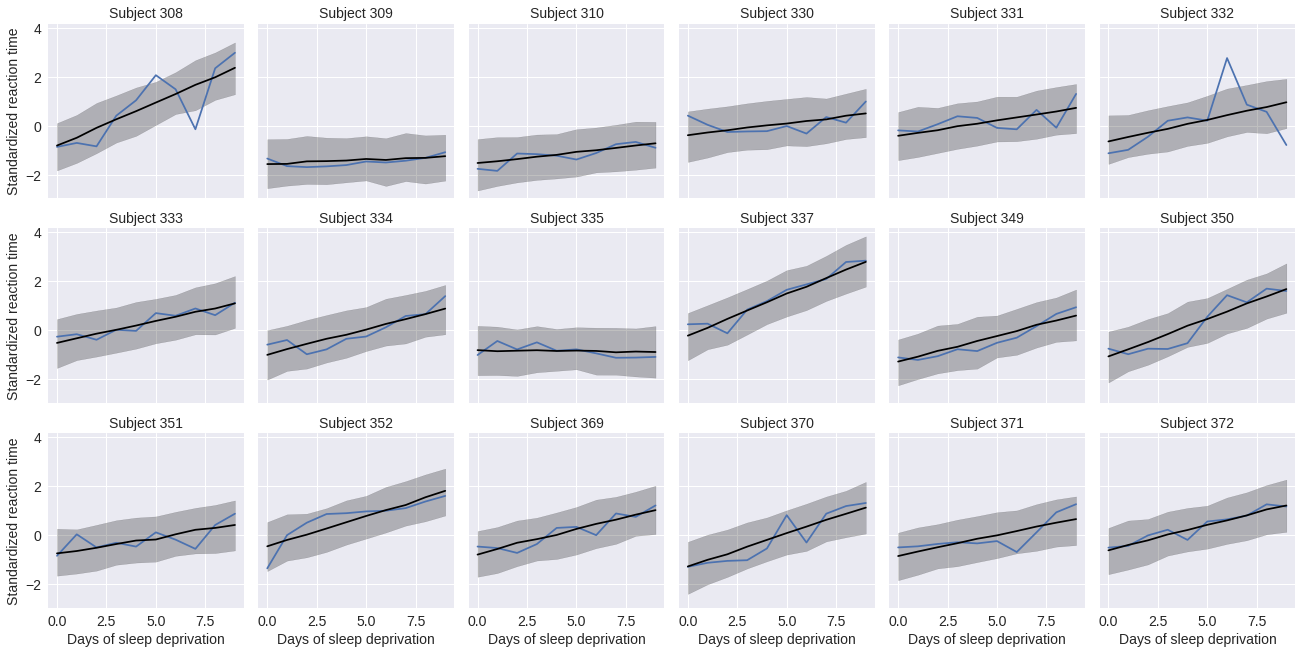

In [46]:
grid.fig

## Hamiltonian Monte Carlo in PyMC3

The following few cells can be ignored, they generate the plot for this slide.

In [47]:
x_ani = np.linspace(0, 1, 100)
y_ani = 1 - 2 * x_ani + np.random.normal(0., 0.25, size=100)

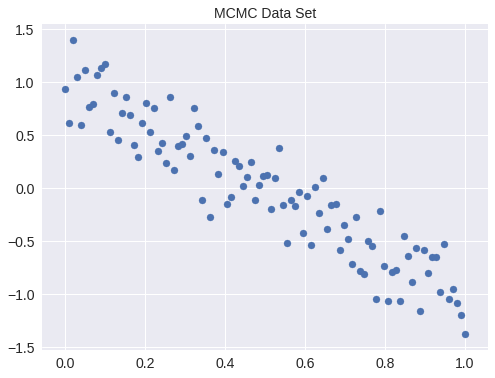

In [48]:
fig, ax = plt.subplots()

ax.scatter(x_ani, y_ani, c=blue);

ax.set_title('MCMC Data Set');

In [49]:
with pm.Model() as mcmc_model:
    β0 = pm.Normal('β0', 0., 10.)
    β = pm.Normal('β', 0., 10.)
    
    σ = pm.HalfCauchy('σ', 5.)
    y_obs = pm.Normal('y_obs', β0 + β * x_ani, σ, observed=y_ani)
    
    mcmc_trace = pm.sample(random_seed=SEED)[:100]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:01<00:00, 689.19it/s]


In [50]:
mcmc_cov = np.cov(mcmc_trace['β0'], mcmc_trace['β'])

mcmc_sigma, mcmc_U = np.linalg.eig(mcmc_cov)
mcmc_angle = 180. / np.pi * np.arccos(np.abs(mcmc_U[0, 0]))

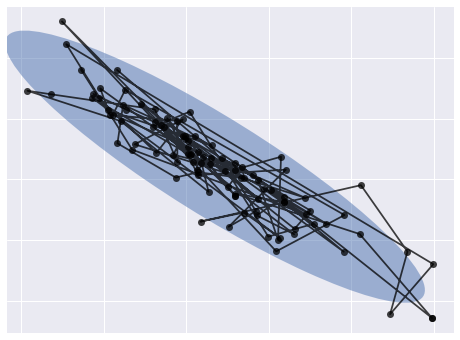

In [51]:
mcmc_fig, mcmc_ax = plt.subplots()

e = Ellipse((mcmc_trace['β0'].mean(), mcmc_trace['β'].mean()),
            2 * np.sqrt(5.991 * mcmc_sigma[0]), 2 * np.sqrt(5.991 * mcmc_sigma[1]),
            angle=mcmc_angle, zorder=5)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(1)

mcmc_ax.plot(mcmc_trace['β0'], mcmc_trace['β'],
             '-o', c='k', alpha=0.75);

mcmc_ax.add_artist(e);

mcmc_ax.set_xticklabels([]);

mcmc_ax.set_yticklabels([]);

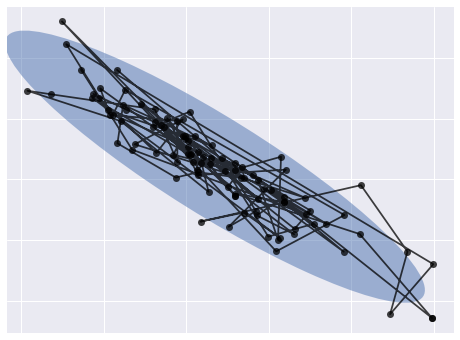

In [52]:
mcmc_fig

### The Curse of Dimensionality

The [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) is a well-known concept in machine learning.  It refers to the fact that as the number of dimensions in the sample space increases, samples become (on average) far apart quite quickly.  It is related to the more complicated phenomenon of [concentration of measure](https://en.wikipedia.org/wiki/Concentration_of_measure), which is the actual motivation for Hamiltonian Monte Carlo (HMC) algorithms.

The following plot illustrates one of the one aspect of the curse of dimensionality, that the volume of the unit ball tends to zero as the dimensionality of the space becomes large.  That is, if

$$
\begin{align*}
S_d
    & = \left\{\left.\vec{x} \in \mathbb{R}^d\ \right|\ x_1^2 + \cdots + x_d^2 \leq 1\right\}, \\
\operatorname{Vol}(S_d)
    & = \frac{2 \pi^{\frac{d}{2}}}{d\ \Gamma\left(\frac{d}{2}\right)}.
\end{align*}$$

And we get that $\operatorname{Vol}(S_d) \to 0$ as $d \to \infty$.

In [53]:
def sphere_volume(d):
    return 2. * np.power(np.pi, d / 2.) / d / sp.special.gamma(d / 2)

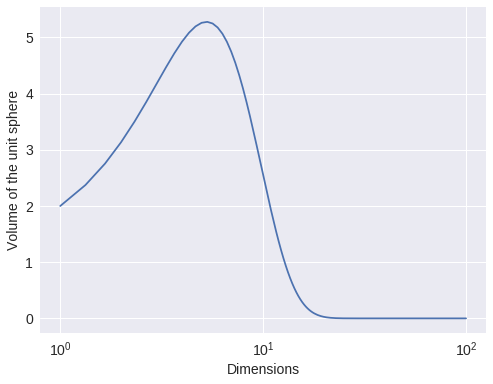

In [54]:
fig, ax = plt.subplots()

d_plot = np.linspace(1, 100, 300)

ax.plot(d_plot, sphere_volume(d_plot));

ax.set_xscale('log');
ax.set_xlabel("Dimensions");

ax.set_ylabel("Volume of the unit sphere");

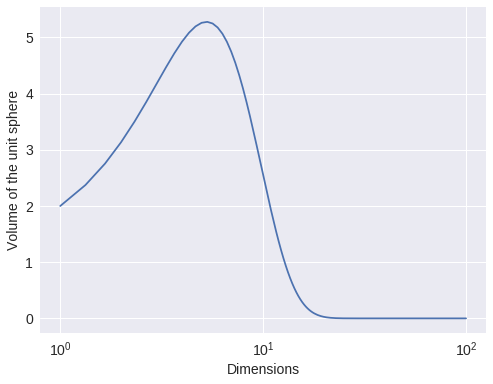

In [55]:
fig

### Hamiltonian Monte Carlo

<center><img src="https://upload.wikimedia.org/wikipedia/commons/6/61/Gaussian_curvature.svg" width="500"></center>

HMC algorithms mitigate the problems introduced the the curse of dimensionality/concentration of measure by taking into account the curvature of the posterior distribution.  Its benefits are most apparent in models with many parameters, which correspond to high-dimesional posterior spaces.  For an introduction to HMC algorithms, consult Michael Betancourt's [_A Conceptual Introduction to Hamiltonian Monte Carlo_](https://arxiv.org/abs/1701.02434).

The [mathematical quantification of curvature](https://en.wikipedia.org/wiki/Differential_geometry) necessary for HMC algorithms involves differentiating various aspects of the model.  PyMC3 uses Theano for automatic differentiation of tensor expressions to perform HMC sampling.

<center><img src="http://www.deeplearning.net/software/theano/_static/theano_logo.png"></center>

$$\frac{d}{dx} \left(x^3\right) = 3 x^2$$

In [56]:
x = tt.dscalar('x')
x.tag.test_value = 0.

y = x**3

In [57]:
from theano import pprint

pprint(tt.grad(y, x))

'((fill((x ** TensorConstant{3}), TensorConstant{1.0}) * TensorConstant{3}) * (x ** (TensorConstant{3} - TensorConstant{1})))'

### Case Study: 1984 Congressional Votes

To illustrate the benefits of the HMC algorithms that PyMC3 gives easy access to, we use a [data set](https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/) of key 1984 US congressional votes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

In [58]:
%%bash
export DATA_URI='https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

if [[ ! -e /tmp/house-votes-84.data ]]
then
    wget -O /tmp/house-votes-84.data $DATA_URI
fi

In [59]:
N_BILL = 16
BILL_COLS = list(range(N_BILL))


vote_df = (pd.read_csv('/tmp/house-votes-84.data',
                      names=['party'] + BILL_COLS)
            .rename_axis('rep_id', axis=0)
            .reset_index())

In [60]:
vote_df.head()

,rep_id,party,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


**Question:** can we separate Democrats and Republicans based on their voting records?

In [61]:
n_rep, _ = vote_df.shape

We [melt](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html) the wide `DataFrame` to a tidy form, which is easier to use for exploration and modeling.

In [62]:
vote_df['party_id'], party_map = vote_df.party.factorize()

long_df = (pd.melt(vote_df, id_vars=['rep_id', 'party_id'], value_vars=BILL_COLS,
                   var_name='bill_id', value_name='vote_raw')
             .assign(bill_id=lambda df: df.bill_id.astype(np.int64),
                     vote=lambda df: np.where(df.vote_raw == 'y', 1,
                                              np.where(df.vote_raw == 'n', 0, np.nan)))
             .dropna()
             .drop('vote_raw', axis=1))

In [63]:
long_df.head()

,rep_id,party_id,bill_id,vote
0,0,0,0,0.0
1,1,0,0,0.0
3,3,1,0,0.0
4,4,1,0,1.0
5,5,1,0,0.0


The following plot shows the proportion of representatives that voted for each bill, broken down by party.  The often large gaps between parties shows that it should be possible to separate Democrats and Republicans based only on their voting records.

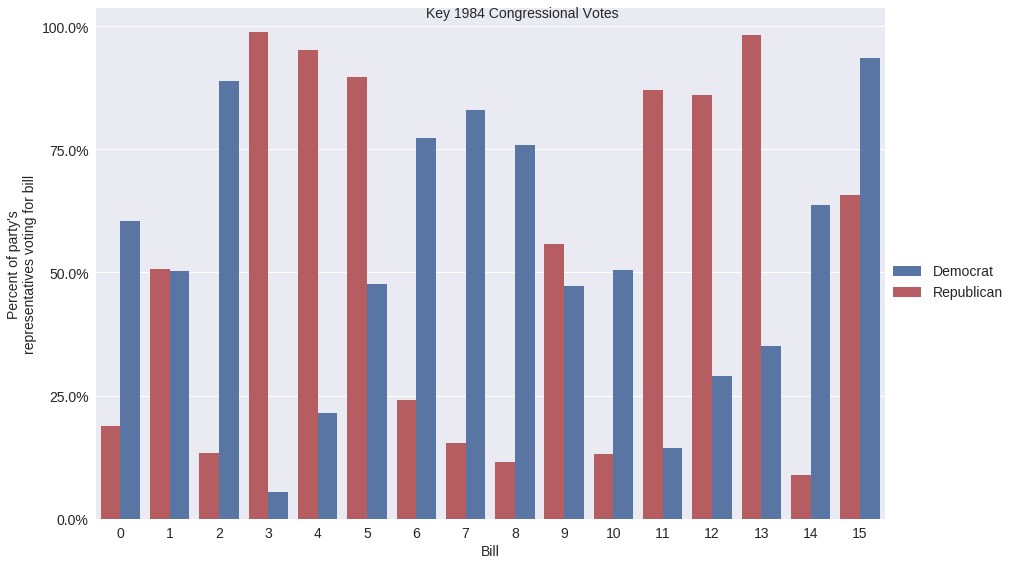

In [64]:
grid = sns.factorplot('bill_id', 'vote', 'party_id', long_df,
                      kind='bar', ci=None, size=8, aspect=1.5, legend=False,
                      palette=[red, blue]);

ax = grid.axes[0, 0]
ax.set_yticks(np.linspace(0, 1, 5));
ax.yaxis.set_major_formatter(pct_formatter);

grid.set_axis_labels('Bill', 'Percent of party\'s\nrepresentatives voting for bill');
grid.add_legend(legend_data={party_map[int(key)].capitalize(): artist
                             for key, artist in grid._legend_data.items()});
grid.fig.suptitle('Key 1984 Congressional Votes');

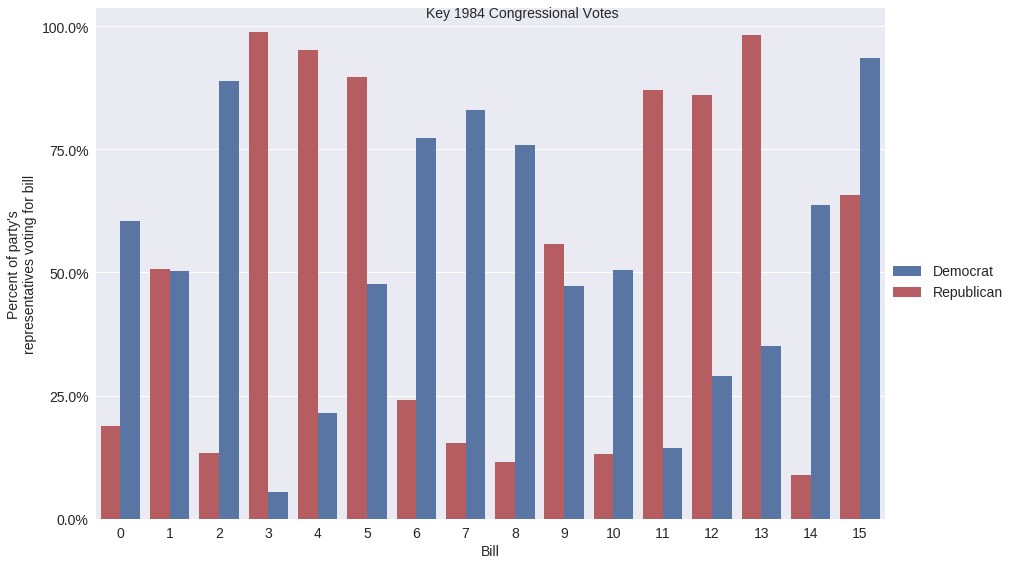

In [65]:
grid.fig

We now build an [ideal point model](https://en.wikipedia.org/wiki/Item_response_theory) of representative's voting patterns.  For more information on Bayesian ideal point models, consult Gelman and Bafumi's [_Practical Issues in Implementing and Understanding Bayesian Ideal Point Estimation_](http://www.stat.columbia.edu/~gelman/research/published/171.pdf).

**Latent State Model**

* Representatives ($\color{blue}{\theta_i}$) and bills ($\color{green}{b_j})$ have _ideal points_ on a liberal-conservative spectrum.
    * If the ideal points are equal, there is a 50% chance the representative will vote for the bill.

**Optional**

The following `hierarchical_normal` function implements a hierarchical normal prior distribution equivalent to those we used for the varying slopes and intercepts for the sleep deprivation case study.  However, for our high-dimensional ideal point model, a [noncentered parametrization](http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) of this prior will lead to more efficient sampling than the naive parametrization we used previously.

In [66]:
def hierarchical_normal(name, shape):
    μ = pm.Normal('μ_{}'.format(name), 0., 1.)
    Δ = pm.Normal('Δ_{}'.format(name), 0., 1., shape=shape)
    σ = pm.Normal('σ_{}'.format(name), 5.)
    
    return pm.Deterministic(name, μ + Δ * σ)

In [67]:
rep_id = long_df.rep_id.values
bill_id = long_df.bill_id.values

vote = long_df.vote.values

In [68]:
with pm.Model() as vote_model:
    # representative ideal points
    θ = pm.Normal('θ', 0., 1., shape=n_rep)
    
    # bill ideal points
    a = hierarchical_normal('a', N_BILL)

The following potential is necessary to [identify](https://en.wikipedia.org/wiki/Identifiability) the model.  It restricts the second representative, a Republican, to have a positive ideal point.  Conventionally in political science, conservativity corresponds to positive ideal points.  See the Gelman and Bafumi paper referenced above for a discussion of why this restriction is necessary.

In [69]:
with vote_model:
    θ_pot = pm.Potential('θ_pot', tt.switch(θ[1] < 0., -np.inf, 0.))

* Bills also have an ability to _discriminate_ ($\color{red}{a_j}$) between conservative and liberal representatives.
    * Some bills have broad bipartisan support, while some provoke votes along party lines.

In [70]:
with vote_model:
    # bill discrimination parameters
    b = hierarchical_normal('b', N_BILL)

This model has

In [71]:
n_rep + 2 * (N_BILL + 1)

469

parameters

This model is a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) with latent parameters.

**Observation Model**

$$
\begin{align*}
P(\textrm{Representative }i \textrm{ votes for bill }j\ |\ \color{blue}{\theta_i}, \color{green}{b_j}, \color{red}{a_j})
    & = \frac{1}{1 + \exp\left(-\left(\color{red}{a_j} \cdot \color{blue}{\theta_i} - \color{green}{b_j}\right)\right)}
\end{align*}
$$

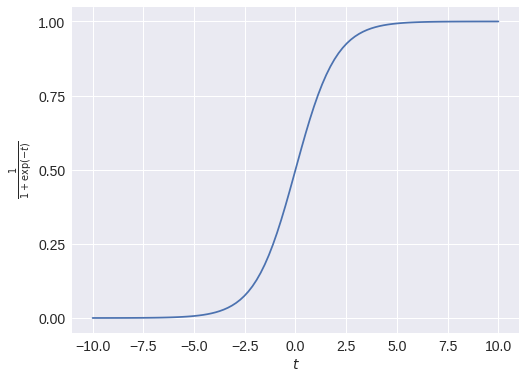

In [72]:
fig, ax = plt.subplots()

t_plot = np.linspace(-10, 10, 100)
ax.plot(t_plot, sp.special.expit(t_plot));

ax.set_xlabel("$t$");

ax.set_yticks(np.linspace(0, 1, 5));
ax.set_ylabel(r"$\frac{1}{1 + \exp(-t)}$");

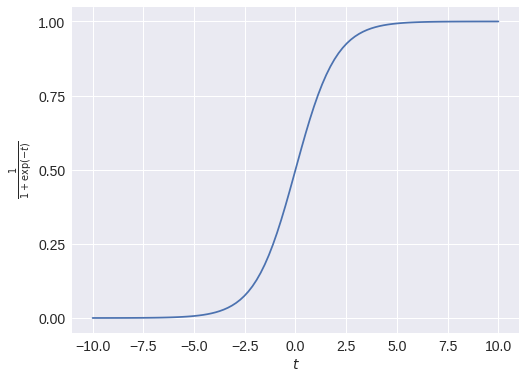

In [73]:
fig

$$
\begin{align*}
P(\textrm{Representative }i \textrm{ votes for bill }j\ |\ \color{blue}{\theta_i}, \color{green}{b_j}, \color{red}{a_j})
    & = \frac{1}{1 + \exp\left(-\left(\color{red}{a_j} \cdot \color{blue}{\theta_i} - \color{green}{b_j}\right)\right)}
\end{align*}
$$

In [74]:
with vote_model:
    η = a[bill_id] * θ[rep_id] - b[bill_id]
    p = pm.math.sigmoid(η)
    
    obs = pm.Bernoulli('obs', p, observed=vote)

**Hamiltonian Monte Carlo Inference**

In [75]:
with vote_model:
    nuts_trace = pm.sample(init='adapt_diag', njobs=N_JOBS,
                           random_seed=JOB_SEEDS)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
100%|██████████| 1000/1000 [02:11<00:00, 12.76it/s]


### Convergence Diagnostics

We see that the chains appear to have converged well.

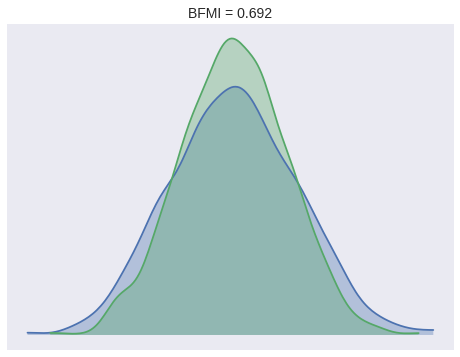

In [76]:
ax = pm.energyplot(nuts_trace, legend=False)
ax.set_title("BFMI = {:.3f}".format(pm.bfmi(nuts_trace)));

In [77]:
max(np.max(gr_values) for gr_values in pm.gelman_rubin(nuts_trace).values())

1.0135857288309107

### Ideal Points

The model has effectively separated Democrats from Republicans, soley based on their voting records.

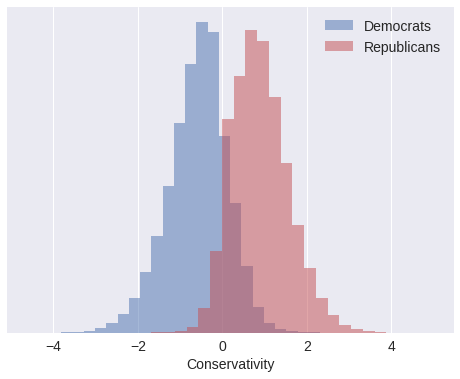

In [78]:
fig, ax = plt.subplots()

dem_ids = vote_df[vote_df.party == 'democrat'].rep_id.values
rep_ids = vote_df[vote_df.party == 'republican'].rep_id.values

ax.hist(nuts_trace['θ'][:, dem_ids].ravel(),
        bins=30, normed=True, alpha=0.5,
        color=blue, label='Democrats');
ax.hist(nuts_trace['θ'][:, rep_ids].ravel(),
        bins=30, normed=True, alpha=0.5,
        color=red, label='Republicans');

ax.set_xlabel("Conservativity");

ax.set_yticks([]);

ax.legend();

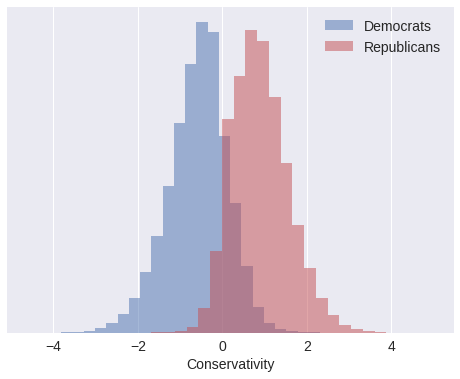

In [79]:
fig

### Discriminative Ability of Bills

The following plot shows that it was important to include the discrimination parameters `a`, as some bills are quantifiably more useful for separating Democrats from Republicans.

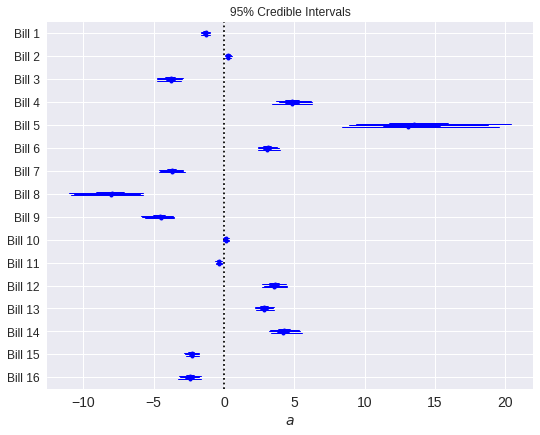

In [80]:
pm.forestplot(nuts_trace, varnames=['a'], rhat=False, xtitle="$a$",
              ylabels=["Bill {}".format(i + 1) for i in range(N_BILL)]);

### Comparison to Non-Hamiltonian MCMC

We now use standard MCMC methods (in this case, the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm) on this model to illustrate the power of HMC algorithms.

In [81]:
with vote_model:
    step = pm.Metropolis()
    met_trace_ = pm.sample(10000, step, njobs=N_JOBS, random_seed=JOB_SEEDS)
    
met_trace = met_trace_[5000::5]

100%|██████████| 10500/10500 [03:40<00:00, 47.65it/s]


We see that the standard MCMC samples are quite far from converging, as their Gelman-Rubin statistics vastly exceed one.

In [82]:
max(np.max(gr_values) for gr_values in pm.gelman_rubin(met_trace).values())

39.87901257961822

The following plot shows the vast difference between the standard MCMC and HMC samples, and the low quality of the standard MCMC samples.

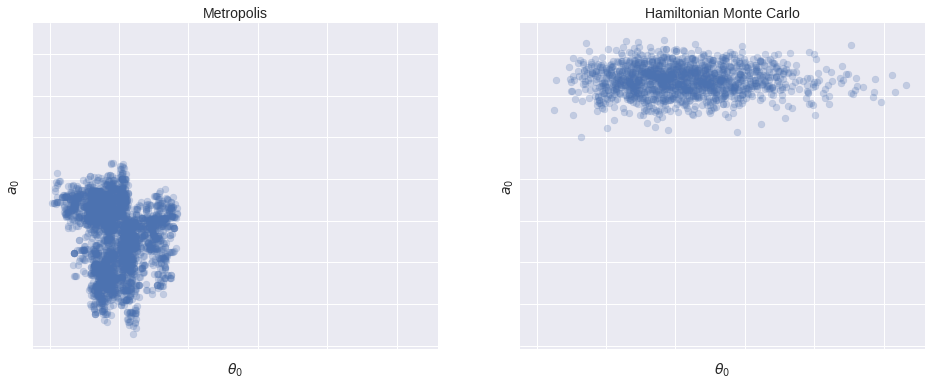

In [83]:
fig, (met_ax, nuts_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

met_ax.scatter(met_trace['θ'][:, 0], met_trace['a'][:, 0],
               alpha=0.25);

met_ax.set_xticklabels([]);
met_ax.set_xlabel(r"$θ_0$");

met_ax.set_yticklabels([]);
met_ax.set_ylabel("$a_0$");

met_ax.set_title("Metropolis");

nuts_ax.scatter(nuts_trace['θ'][:, 0], nuts_trace['a'][:, 0],
                alpha=0.25);

nuts_ax.set_xlabel(r"$θ_0$");
nuts_ax.set_ylabel("$a_0$");
nuts_ax.set_title("Hamiltonian Monte Carlo");

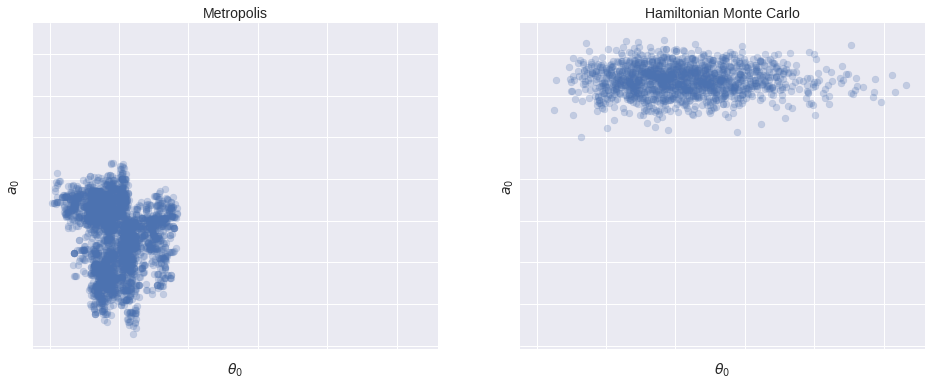

In [84]:
fig

## Next Steps

The following books/GitHub repositories provide good introductions to PyMC3 and Bayesian statistics.

### PyMC3

<table>
    <tr>
        <td>
            <a href="https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers#pymc3"><img src="https://camo.githubusercontent.com/4a0aca82ca82efab71747d00db30f3a68de98e82/687474703a2f2f692e696d6775722e636f6d2f36444b596250622e706e673f31" width="300"></a>
            <br>
        </td>
        <td>
            <a href="https://www.packtpub.com/big-data-and-business-intelligence/bayesian-analysis-python"><img src="https://d255esdrn735hr.cloudfront.net/sites/default/files/imagecache/ppv4_main_book_cover/3804OS_4958_Bayesian%20Analysis%20with%20Python.jpg"></a>
        </td>
        <td>
            <a href="https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3"><img src="http://xcelab.net/rm/wp-content/uploads/2012/01/9781482253443.jpg" width="250"></a>
        </td>
    </tr>
</table>

The following chart gives an overview of the larger probabilistic programming ecosystem.

## Probabilistic Programming Ecosystem

<table>
    <tr>
        <th>Probabilistic Programming System</th>
        <th>Language</th>
        <th>License</th>
        <th>Discrete Variable Support</th>
        <th>Automatic Differentiation/Hamiltonian Monte Carlo</th>
        <th>Variational Inference</th>
    </tr>
    <tr>
        <td><a href='http://pymc-devs.github.io/pymc3/'>PyMC3</a></td>
        <td>Python</td>
        <td>Apache V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href='http://mc-stan.org/'>Stan</a></td>
        <td>C++, R, Python, ...</td>
        <td>BSD 3-clause</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href="http://edwardlib.org/">Edward</a></td>
        <td>Python, ...</td>
        <td>Apache V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href='http://www.mrc-bsu.cam.ac.uk/software/bugs/'>BUGS</a></td>
        <td>Standalone program, R</td>
        <td>GPL V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
    </tr>
    <tr>
        <td><a href='chrome-extension://ojhmphdkpgbibohbnpbfiefkgieacjmh/app/index.html'>JAGS</a></td>
        <td>Standalone program, R</td>
        <td>GPL V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
    </tr>
</table>

## Thank you!

<img src="https://media1.giphy.com/media/xIJLgO6rizUJi/giphy.gif">

### [@AustinRochford](https://twitter.com/AustinRochford) &#8226; [austin.rochford@gmail.com](mailto:austin.rochford@gmail.com) &#8226; [arochford@monetate.com](mailto:arochford@monetate.com)


The Jupyter notebook used to generate these slides is available [here](https://gist.github.com/AustinRochford/d83ecc6acd17a632a2b9df788386540b).

In [85]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=os-bayes-pymc3-fosscon-2017 \
    ./Open\ Source\ Bayesian\ Inference\ in\ Python\ with\ PyMC3.ipynb

[NbConvertApp] Converting notebook ./Open Source Bayesian Inference in Python with PyMC3.ipynb to slides
[NbConvertApp] Writing 1553020 bytes to ./os-bayes-pymc3-fosscon-2017.slides.html
